Решить краевую задачу для дифференциального уравнения эллиптического типа. Аппроксимацию уравнения произвести с использованием центрально-разностной схемы. Для решения дискретного аналога применить следующие методы: метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией. Вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,y)$.  Исследовать зависимость погрешности от сеточных параметров $h_x$, $h_y$.

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + u = 0 $$
$ u_x(0, y) = y \\ u_x(\frac{\pi}{2}, y) = 0 \\ u(x, 0) = 0 \\ u(x, 1) = sin(x) $

$$ U(x, y) = y sin(x)$$

In [11]:
import math
import typing
from typing import List
import matplotlib.pyplot as plt

### Входные условия

In [12]:
x_left = 0
x_right = math.pi/2
y_left = 0
y_right = 1
a = 1
b = 1
c = 1
alpha_1, betta_1 = 1, 0
alpha_2, betta_2 = 1, 0
alpha_3, betta_3 = 0, 1
alpha_4, betta_4 = 0, 1

In [13]:
def phi_1(y:float) -> float:
    return y

def phi_2(y:float) -> float:
    return 0

def phi_3(x:float) -> float:
    return 0

def phi_4(x:float) -> float:
    return math.sin(x)

def f(x:float, y:float) -> float:
    return 0

def U(x:float, y:float) -> float:
    return y * math.sin(x)

def real_U(X:list, Y:list) -> list:
    n = len(X)
    m = len(Y)
    U_true = [[0] * n for _ in range(m)]
    for k in range(m):
        for j in range(n):
            U_true[k][j] = U(X[j], Y[k])
    return U_true

### Вспомогательные функиции

графики

In [14]:

def plot_graphs(new_X:list, new_T:list, found_U:list, U_true:list, s:str='') -> None:
    plt.plot(new_X, U_true[len(new_T) // 4 ],  label='Аналитическое решение')
    plt.plot(new_X, found_U[len(new_T) // 4 ], label=s, linestyle='dashdot')
    plt.plot(new_X, U_true[len(new_T) // 2 ], label='Аналитическое решение')
    plt.plot(new_X, found_U[len(new_T) // 2 ], label=s, linestyle='dashdot')
    plt.plot(new_X, U_true[len(new_T) - 1], label='Аналитическое решение')
    plt.plot(new_X, found_U[len(new_T) - 1],label=s, linestyle='dashdot')
    plt.legend()

график ошибки от h

In [15]:
def error (U_my:list, U_true:list) -> float:
    return sum([abs(a - b) for a, b in zip(U_my, U_true)])
def get_error_array_with_h(N:list, left:float, right:float, a:float, b:float, c:float, d:float, alpha:float, betta:float, gamma:float, delta:float, find_u:typing.Callable, t_end:float=1, appoximation:int=1, appoximation_start:float=1) -> (list, list): # H, error
    H = [right/(n - 1) for n in N]
    ERROR = []
    for n in N:
        XX, TT, UU = find_u(left, right, a, b, c, d, alpha, betta, gamma, delta, n=n, t_end=t_end, appoximation=appoximation, appoximation_start=appoximation_start)
        U_true = real_U(XX, TT)
        t = len(TT) // 2
        ERROR.append(error(UU[t], U_true[t]))
    
    return H, ERROR

In [16]:
def frange(start:float, stop:float, step:float) -> float:
    while start < stop:
        yield start
        start += step

In [17]:
def get_y(y0:float, y_end:float, h:float) -> list:
    return [i for i in frange(y0, y_end+h, h)]

def get_x(x_0:float, x_l:float, h:float) -> list:
    return [i for i in frange(x_0, x_l+h, h)]

Отношение конечной разности по схеме

$$\frac{u_{i+1, j} - 2 u_{i, j} + u_{i-1, j}}{h_1^2}  + \frac{u_{i, j+1} - 2 u_{i, j} + u_{i, j-1}}{h_2^2} + O(h_1^2 + h_2^2) = f(x_i, y_i)$$

мой случай 
$$ \frac{u_{i+1, j} - 2 u_{i, j} + u_{i-1, j}}{h_1^2}  +  \frac{u_{i, j+1} - 2 u_{i, j} + u_{i, j-1}}{h_2^2} + c u_{i, j} = f(x_i, y_i) $$

### Метод Лимбмана

In [18]:
def error(U_prev:List[List[float]], U_values:List[List[float]]) -> float:
    eps = 0
    for i in range(len(U_prev)):
        for j in range(len(U_prev[0])):
            eps = max(eps, abs(U_prev[i][j] - U_values[i][j]))
    print(eps)
    return eps

def limbman(x_left:float, x_right:float, y_left:float, y_right:float, a:float, b:float, c:float, d:float=0, eps:float=0.1, n_x:float=10, n_y:float=10) -> (List[float], List[float], List[List[float]]):
    hx = x_right / (n_x - 1)
    hy = y_right / (n_y - 1)
    X = get_x(x_left, x_right, hx)
    Y = get_y(y_left, y_right, hy)

    U_values = [[0] * len(X) for _ in range(len(Y))]
    U_prev = [[10] * len(X) for _ in range(len(Y))]

    for i in range(len(Y)):
        U_values[i][0] = phi_2(Y[0])
        U_values[i][-1] = phi_1(Y[i])
    for i in range(len(X)):
        U_values[0][i] = phi_3(X[i])
        U_values[-1][i] = phi_4(X[i])
    print(np.array(U_values))
    delta = 1/(2/hx**2 + 2/hy**2 + c)
    hhx = 1/hx**2
    ahx = a/2/hx
    hhy = 1/hy**2
    bhy = b/2/hy
    # return X, Y, U_values
    cnt = 0
    # while (error(U_prev, U_values) > eps):
    while (cnt < 1/eps):

        U_prev = list(U_values)
        for i in range(1, len(Y) - 1):
            for j in range(1, len(X) - 1):

                ##U_values[i+1][j] = 2 * U_values[i][j] - U_values[i-1][j] - (hx / hy) ** 2 * (U_values[i][j+1] - 2 * U_values[i][j] + U_values[i][j-1]) - hx**2 * c * U_values[i][j] - hx**2 * f(X[i], Y[j])
                U_values[i][j] = (hx * hx * f(X[i],Y[j]) - (U_prev[i+1][j] + U_prev[i-1][j]) - d * hx * hx * (U_prev[i][j+1] +
                                 U_prev[i][j-1]) / (hy * hy) - a * hx * (U_prev[i+1][j] - U_prev[i-1][j]) / 2 - b * hx * hx * (U_prev[i][j+1] -
                                 U_prev[i][j-1]) / (2 * hy)) / (c * hx * hx - 2 * (hy * hy + d * hx * hx)/ (hy * hy))
                
                # U_values[i][j] = delta * ((hhx + ahx) * U_prev[i - 1][j] +
                #                        (hhx - ahx) * U_prev[i + 1][j] +
                #                        (hhy + bhy) * U_prev[i][j - 1] +
                #                        (hhy - bhy) * U_prev[i][j + 1])

        cnt +=1

    print(cnt)
    return X, Y, U_values

In [19]:
X, Y, UU = limbman(x_left, x_right, y_left, y_right, a, b, c, d=0, eps=0.1, n_x=10, n_y=10)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.11111111]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.22222222]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.44444444]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.55555556]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.77777778]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.88888889]
 [0.         0.17364818 0.34202014 0.

In [20]:
U_true = real_U(X, Y)

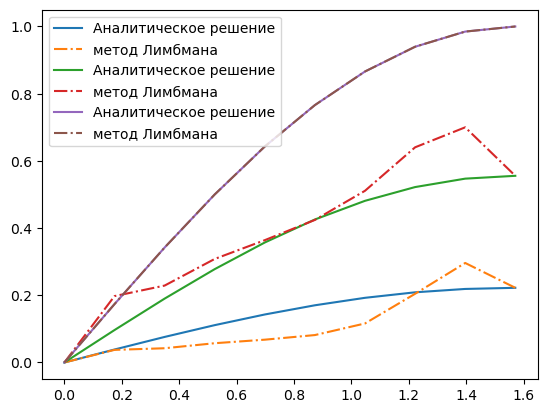

In [21]:
plot_graphs(X, Y, UU, U_true, 'метод Лимбмана')

In [22]:
import numpy as np
np.array(U_true)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01929424, 0.03800224, 0.05555556, 0.07142085,
        0.08511605, 0.09622504, 0.10441029, 0.10942308, 0.11111111],
       [0.        , 0.03858848, 0.07600448, 0.11111111, 0.14284169,
        0.1702321 , 0.19245009, 0.20882058, 0.21884617, 0.22222222],
       [0.        , 0.05788273, 0.11400671, 0.16666667, 0.21426254,
        0.25534815, 0.28867513, 0.31323087, 0.32826925, 0.33333333],
       [0.        , 0.07717697, 0.15200895, 0.22222222, 0.28568338,
        0.3404642 , 0.38490018, 0.41764116, 0.43769233, 0.44444444],
       [0.        , 0.09647121, 0.19001119, 0.27777778, 0.35710423,
        0.42558025, 0.48112522, 0.52205146, 0.54711542, 0.55555556],
       [0.        , 0.11576545, 0.22801343, 0.33333333, 0.42852507,
        0.5106963 , 0.57735027, 0.62646175, 0.6565385 , 0.66666667],
       [0.        , 0.13505969, 0.2660156

In [23]:
np.array(UU)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01239306, 0.01431325, 0.01946868, 0.02321868,
        0.02845942, 0.04413692, 0.09081916, 0.14915644, 0.11111111],
       [0.        , 0.03751914, 0.04234525, 0.05731905, 0.06784122,
        0.08159009, 0.11612825, 0.20444586, 0.29614873, 0.22222222],
       [0.        , 0.07956288, 0.08912328, 0.1201818 , 0.14162188,
        0.1678275 , 0.22248718, 0.34079252, 0.43985287, 0.33333333],
       [0.        , 0.13627178, 0.15387908, 0.20708907, 0.24386406,
        0.28603153, 0.35901573, 0.49104401, 0.5760575 , 0.44444444],
       [0.        , 0.19752261, 0.22884224, 0.30810202, 0.36403484,
        0.42424212, 0.51099149, 0.64039118, 0.69988134, 0.55555556],
       [0.        , 0.24721403, 0.30053732, 0.40627865, 0.48396462,
        0.56248374, 0.6572954 , 0.77235381, 0.80699018, 0.66666667],
       [0.        , 0.26773094, 0.3528398

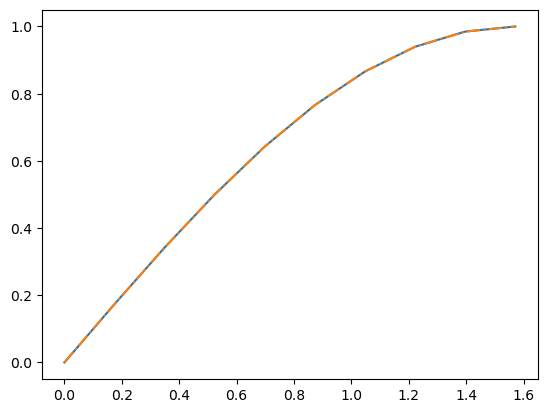

In [24]:
plt.plot(X, U_true[-1])
plt.plot(X, UU[-1], linestyle='dashdot')
plt.show()

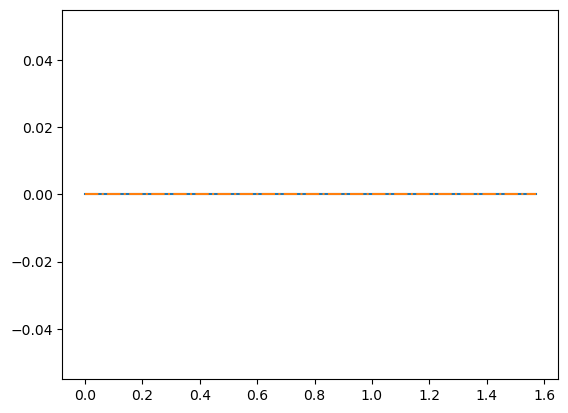

In [25]:
plt.plot(X, U_true[0])
plt.plot(X, UU[0], linestyle='dashdot')
plt.show()

### Метод Зейделя

In [26]:
def Seidel():
    hx = x_right / (n_x - 1)
    hy = y_right / (n_y - 1)
    X = get_x(x_left, x_right, hx)
    Y = get_y(y_left, y_right, hy)

    U_values = [[0] * len(X) for _ in range(len(Y))]
    U_prev = [[10] * len(X) for _ in range(len(Y))]

    for i in range(len(X)):
        U_values[i][0] = phi_1(Y[i])
        U_values[i][-1] = phi_2(Y[i])  
    for i in range(len(Y)):
        U_values[0][i] = phi_3(X[i])
        U_values[-1][i] = phi_4(X[i])

### Метод простых итераций с верхней релаксацией

In [27]:
def relax():
    hx = x_right / (n_x - 1)
    hy = y_right / (n_y - 1)
    X = get_x(x_left, x_right, hx)
    Y = get_y(y_left, y_right, hy)

    U_values = [[0] * len(X) for _ in range(len(Y))]
    U_prev = [[10] * len(X) for _ in range(len(Y))]

    for i in range(len(X)):
        U_values[i][0] = phi_1(Y[i])
        U_values[i][-1] = phi_2(Y[i])  
    for i in range(len(Y)):
        U_values[0][i] = phi_3(X[i])
        U_values[-1][i] = phi_4(X[i])